In [1]:
import sys
import numpy as np
import cPickle
import h5py
sys.path.append('../..')
sys.path.append('../../..')
from tsne_python.tsne import tsne
import matplotlib.pyplot as plt
np.random.seed(7)
from sklearn.decomposition import PCA

def getHDF5Data(f):
    ff = h5py.File(f,mode='r')
    alldata = {}
    for k in ff.keys():
        alldata[k] = ff[k].value
    return alldata
def getPKLData(f):
    with open(f,'rb') as f:
        data = cPickle.load(f)
    return data

def plotWithOriginalAndCfac(x_original, x_gender, x_opposite_gender, gender='male', transform='None', title=''):
    # N(1) * T(5) * Obs(183)    
    assert x_original.shape == x_gender.shape == x_opposite_gender.shape
    assert len(x_original.shape) == 3
    assert x_original.shape[0] == 1
    
    T = x_original.shape[1]
    # 3T * Obs(183)
    X = np.concatenate((x_original[0], x_gender[0], x_opposite_gender[0]), axis=0)
    
    if transform == 'PCA':
        pca = PCA(n_components=2)
        Y=pca.fit_transform(X)
        axis1_ratio = pca.explained_variance_ratio_[0]
        axis2_ratio = pca.explained_variance_ratio_[1]
        axis1_text = 'PC 1 (%.2f%%)' % (axis1_ratio*100)
        axis2_text = 'PC 2 (%.2f%%)' % (axis2_ratio*100)
    elif transform == 'tsne':
        Y = tsne(X, 2, 50, 30.0, quiet=True)
        axis1_text = 'tsne axis 1'
        axis2_text = 'tsne axis 2'
    elif transform == 'None':
        Y = X
        axis1_text = 'hidden state 1'
        axis2_text = 'hidden state 2'
    print 'Y shape:', Y.shape
    print 'T', T
    
    label = np.array(range(1, 1+T), dtype=int)
    # Green is original
    plt_original = plt.scatter(Y[0:T, 0], Y[0:T, 1], s=20, c=label, marker='^', cmap='Oranges')
    cmap = 'Blues' if gender == 'male' else 'Reds'
    plt_gender = plt.scatter(Y[T:2*T, 0], Y[T:2*T, 1], s=20, c=label, marker='o', 
                         cmap=cmap)
    cmap = 'Reds' if gender == 'male' else 'Blues'
    plt_opposite_gender = plt.scatter(Y[2*T:3*T, 0], Y[2*T:3*T, 1], s=20, c=label, marker='x', 
                                  cmap=cmap)
    
    legend = plt.legend((plt_original, plt_gender, plt_opposite_gender),
           ('x_observe', 'x_gender', 'x_opposite_gender'),
           scatterpoints=1,
           loc='upper right',
           ncol=3,
           fontsize=8)
    legend.legendHandles[0].set_color('orange')
    legend.legendHandles[1].set_color('blue' if gender=='male' else 'red')
    legend.legendHandles[2].set_color('red' if gender=='male' else 'blue')
    
    cbar = plt.colorbar()
    labels = np.arange(1, 6, 1)
    loc = labels
    cbar.set_ticks(loc)
    cbar.set_ticklabels(labels)
    cbar.ax.set_ylabel('time growth (from light to dark)', rotation=270, labelpad=20)
    
    plt.title('%s %s counterfactual' % (title, gender))
    plt.xlabel(axis1_text)
    plt.ylabel(axis2_text)
    plt.show()
    print Y

def plotAllCfac(male_cfac, gender='male'):
    for index in male_cfac:
        x_original = male_cfac[index]['x']
        x_gender = male_cfac[index]['x_gender']
        x_opposite_gender = male_cfac[index]['x_opposite_gender']

        x_gender = np.concatenate((x_original[0:1,0:1,:], x_gender), axis=1)
        x_opposite_gender = np.concatenate((x_original[0:1,0:1,:], x_opposite_gender), axis=1)

        plotWithOriginalAndCfac(x_original, x_gender, x_opposite_gender, gender=gender, transform='PCA', title='x')

        z_gender = male_cfac[index]['z_gender']
        z_opposite_gender = male_cfac[index]['z_opposite_gender']
        
        if z_gender.shape[1] == 2:
            transform = 'None'
        elif z_gender.shape[1] > 2:
            transform = 'PCA'
        
        plotCfac(z_gender, z_opposite_gender, gender=gender, transform=transform, title='z')

    #     print x_original[0][2]
    #     print x_gender[0][2]
    #     ratio = np.absolute(x_original[0][2]-x_gender[0][2]) / np.absolute(x_original[0][2])
    #     print np.ma.masked_invalid(ratio).sum()
    #     print ratio
    #     break

def plotCfac(x_gender, x_opposite_gender, gender='male', transform='None', title=''):
    
    # N(1) * T(5) * Obs(183)    
    assert x_opposite_gender.shape == x_gender.shape
    assert len(x_gender.shape) == 3
    assert x_gender.shape[0] == 1
    
    T = x_gender.shape[1]
    # 3T * Obs(183)
    X = np.concatenate((x_gender[0], x_opposite_gender[0]), axis=0)
    
    if transform == 'PCA':
        pca = PCA(n_components=2)
        Y=pca.fit_transform(X)
        axis1_ratio = pca.explained_variance_ratio_[0]
        axis2_ratio = pca.explained_variance_ratio_[1]
        axis1_text = 'PC 1 (%f%%)' % (axis1_ratio*100)
        axis2_text = 'PC 2 (%f%%)' % (axis2_ratio*100)
    elif transform == 'tsne':
        Y = tsne(X, 2, 50, 30.0, quiet=True)
        axis1_text = 'tsne axis 1'
        axis2_text = 'tsne axis 2'
    elif transform == 'None':
        Y = X
        axis1_text = 'hidden state 1'
        axis2_text = 'hidden state 2'
    print 'Y shape:', Y.shape
    print 'T', T
    
    label = np.array(range(2, 2+T), dtype=int)
    # Green is original
    cmap = 'Blues' if gender == 'male' else 'Reds'
    plt_gender = plt.scatter(Y[:T, 0], Y[:T, 1], s=20, c=label, marker='o', cmap=cmap)
    cmap = 'Reds' if gender == 'male' else 'Blues'
    plt_opposite_gender = plt.scatter(Y[T:2*T, 0], Y[T:2*T, 1], s=20, c=label, marker='x', cmap=cmap)
    
    legend = plt.legend((plt_gender, plt_opposite_gender),
           ('z_gender', 'z_opposite_gender'),
           scatterpoints=1,
           loc='upper right',
           ncol=3,
           fontsize=8)
    legend.legendHandles[0].set_color('blue' if gender=='male' else 'red')
    legend.legendHandles[1].set_color('red' if gender=='male' else 'blue')
    
    cbar = plt.colorbar()
    labels = np.arange(2, 6, 1)
    loc = labels
    cbar.set_ticks(loc)
    cbar.set_ticklabels(labels)
    cbar.ax.set_ylabel('time growth (from light to dark)', rotation=270, labelpad=20)
    
    
    plt.xlabel(axis1_text)
    plt.ylabel(axis2_text)
    plt.title('%s %s counterfactual' % (title, gender))
    plt.show()

Y shape: (15, 2)
T 5


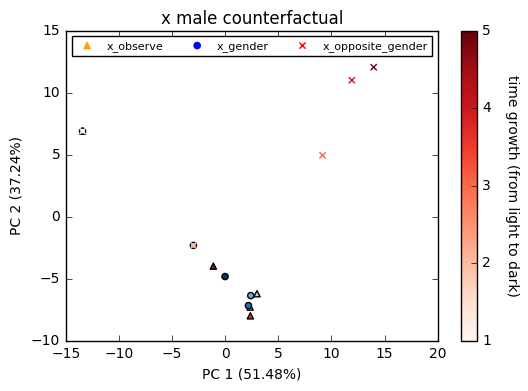

[[ -1.34160982e+01   6.88280325e+00]
 [  2.99192681e+00  -6.22854612e+00]
 [  2.34181017e+00  -7.30296775e+00]
 [  2.36678075e+00  -8.01055952e+00]
 [ -1.11326644e+00  -3.99946426e+00]
 [ -1.34160982e+01   6.88280325e+00]
 [ -2.98763535e+00  -2.33166102e+00]
 [  2.40767099e+00  -6.37862802e+00]
 [  2.19103032e+00  -7.18666010e+00]
 [ -1.04923822e-02  -4.84232838e+00]
 [ -1.34160982e+01   6.88280325e+00]
 [ -2.98763535e+00  -2.33166102e+00]
 [  9.16026803e+00   4.93237298e+00]
 [  1.19139324e+01   1.09896880e+01]
 [  1.39739047e+01   1.20420054e+01]]
Y shape: (8, 2)
T 4


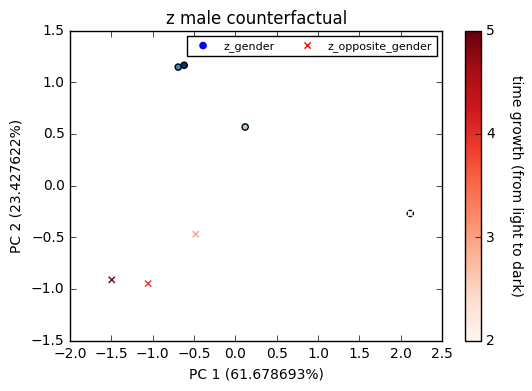

Y shape: (15, 2)
T 5


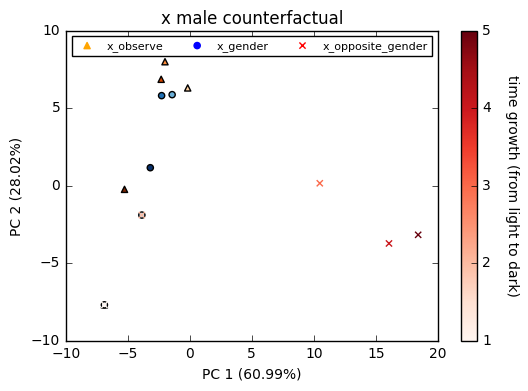

[[ -6.88354402  -7.70025376]
 [ -0.16480173   6.29468754]
 [ -1.99621643   7.98567132]
 [ -2.30528867   6.85192459]
 [ -5.26116204  -0.24823117]
 [ -6.88354402  -7.70025376]
 [ -3.86254072  -1.90736646]
 [ -1.42010744   5.86111302]
 [ -2.26979735   5.79772203]
 [ -3.18164957   1.1475793 ]
 [ -6.88354402  -7.70025376]
 [ -3.86254072  -1.90736646]
 [ 10.48672104   0.14443279]
 [ 16.06735191  -3.73863957]
 [ 18.42066378  -3.18076564]]
Y shape: (8, 2)
T 4


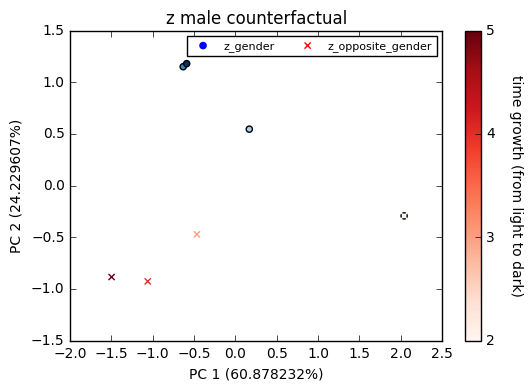

Y shape: (15, 2)
T 5


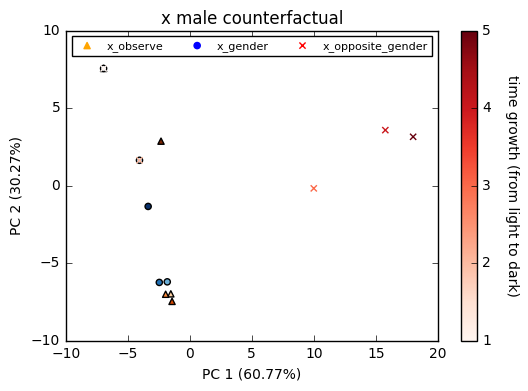

[[ -6.9485059    7.55227181]
 [ -1.52651172  -6.98997118]
 [ -1.94329257  -7.01590336]
 [ -1.42764432  -7.47605892]
 [ -2.31781254   2.86071607]
 [ -6.9485059    7.55227181]
 [ -4.05262701   1.62635287]
 [ -1.81383748  -6.2150902 ]
 [ -2.45465919  -6.25317918]
 [ -3.35480573  -1.3504925 ]
 [ -6.9485059    7.55227181]
 [ -4.05262701   1.62635287]
 [ 10.00211714  -0.18458821]
 [ 15.77278104   3.57257757]
 [ 18.01443711   3.14246874]]
Y shape: (8, 2)
T 4


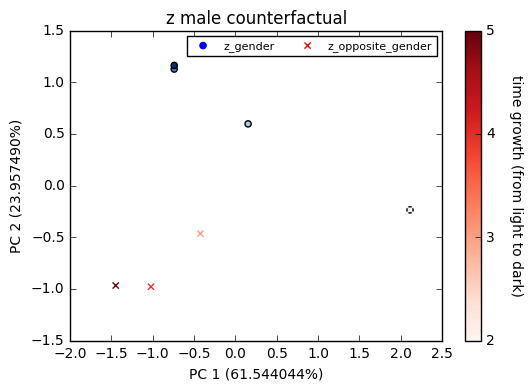

Y shape: (15, 2)
T 5


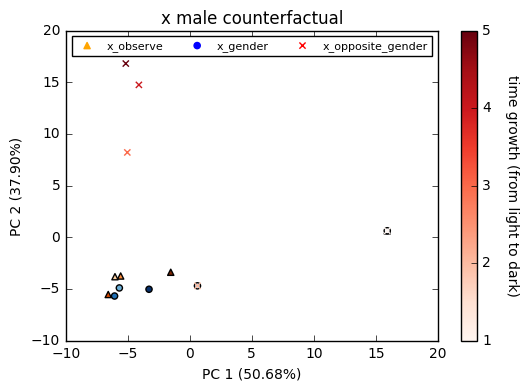

[[ 15.92771829   0.61918451]
 [ -6.03092026  -3.82594093]
 [ -5.57141235  -3.75859257]
 [ -6.57381333  -5.5480233 ]
 [ -1.5328751   -3.39529468]
 [ 15.92771829   0.61918451]
 [  0.62261463  -4.70898292]
 [ -5.6772829   -4.91316988]
 [ -6.06246016  -5.69645429]
 [ -3.28500111  -5.04275832]
 [ 15.92771829   0.61918451]
 [  0.62261463  -4.70898292]
 [ -5.03451519   8.1999965 ]
 [ -4.10223983  14.73845242]
 [ -5.15786391  16.80219737]]
Y shape: (8, 2)
T 4


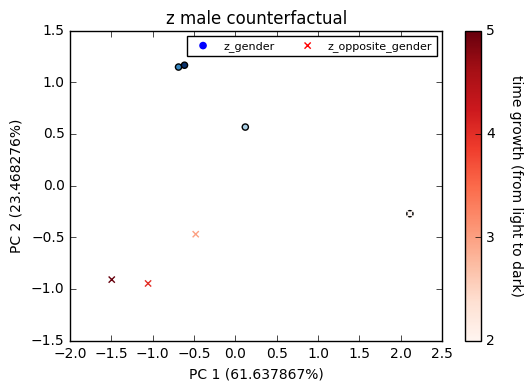

Y shape: (15, 2)
T 5


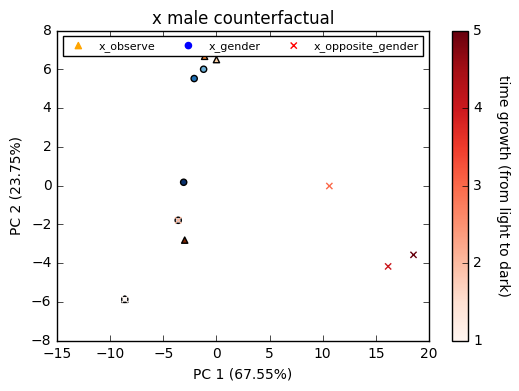

[[ -8.62158464e+00  -5.87438128e+00]
 [  2.49409368e-03   6.49708165e+00]
 [ -1.11182723e+00   6.66713016e+00]
 [ -1.78971467e+00   6.96394265e+00]
 [ -2.98467676e+00  -2.81932084e+00]
 [ -8.62158464e+00  -5.87438128e+00]
 [ -3.59611729e+00  -1.79543630e+00]
 [ -1.20514320e+00   5.99999937e+00]
 [ -2.09255571e+00   5.51978873e+00]
 [ -3.08257337e+00   1.67178197e-01]
 [ -8.62158464e+00  -5.87438128e+00]
 [ -3.59611729e+00  -1.79543630e+00]
 [  1.06246811e+01  -2.61111861e-02]
 [  1.61547553e+01  -4.17666569e+00]
 [  1.85415489e+01  -3.57900658e+00]]
Y shape: (8, 2)
T 4


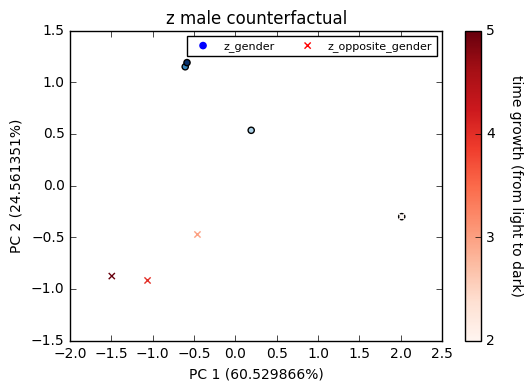

Y shape: (15, 2)
T 5


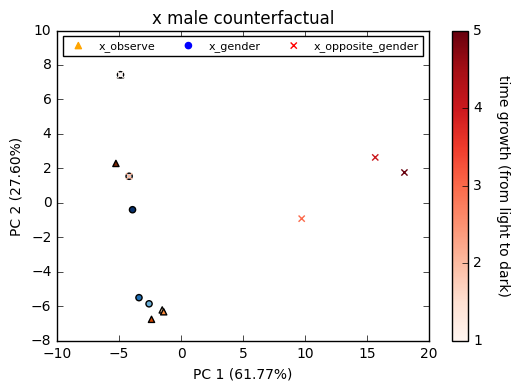

[[ -4.87813669   7.43304731]
 [ -1.5141083   -6.22470613]
 [ -1.39717677  -6.33206783]
 [ -2.37932913  -6.77045434]
 [ -5.24922508   2.28201175]
 [ -4.87813669   7.43304731]
 [ -4.18392198   1.53651882]
 [ -2.57616289  -5.86928719]
 [ -3.38872008  -5.51261526]
 [ -3.90962661  -0.40667127]
 [ -4.87813669   7.43304731]
 [ -4.18392198   1.53651882]
 [  9.73159318  -0.92393554]
 [ 15.66630698   2.63051094]
 [ 18.01870271   1.75503529]]
Y shape: (8, 2)
T 4


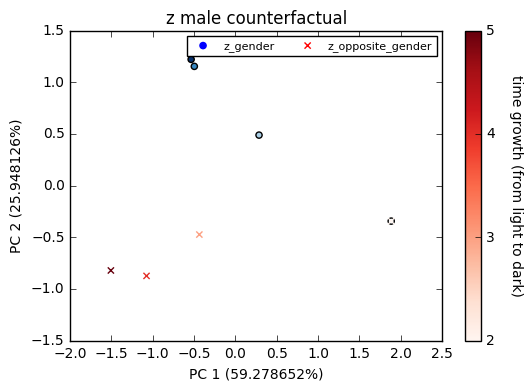

0.635816458408
[ 0.06378708  0.20509878 -0.21573691 -0.09506165  0.00266128  0.22965335
  0.00481608 -0.45226629 -0.03715762 -0.20941039]
0.597714474263
[ 0.32570994 -0.07823332  0.15068081  0.03917446  0.27557257 -0.09501804
 -0.13707558  0.2736944  -0.2047163   0.01549364]
0.57876814434
[ 0.00983833 -0.00777565  0.07543579 -0.13743141  0.10931291  0.53382358
 -0.02647531 -0.02209969  0.07507319 -0.08059226]
0.612561097565
[-0.28711794 -0.17721373  0.20949152  0.09732066 -0.14339591  0.01726338
  0.12476815  0.11849718  0.21205462  0.33555242]
0.559427722999
[-0.03331182 -0.03087601  0.07630519 -0.20684453  0.14421323  0.36854121
 -0.13523128 -0.00402277  0.00404051 -0.29554888]
0.700183150394
[-0.43679493  0.12241974 -0.24521644 -0.22869067  0.00857272  0.05955439
 -0.22515977  0.17675557 -0.29268713  0.02870689]
0.847563330425
[ 0.15436406  0.21716567 -0.13356714 -0.15867015  0.20443317 -0.15643189
  0.04174201  0.6244673   0.38227496 -0.01606854]
0.714060291801
[-0.32964155  0.0278

In [33]:
# For time gender. Looks better.
expt = 'H-time-gender-linear'
uid = 'DKF_lr-5_0000e-03-vm-R-inf-structured-dh-10-ds-10-nl-relu-bs-256-ep-3000-rs-20-ar-1_0000e+01-rv-1_0000e-01-uid'
cfac_file = '../../expt-mouse-puberty/chkpt-%s/%s-cfac.pkl' % (expt, uid)
male_cfac = cfac['male_cfac']

plotAllCfac(male_cfac)

# Do it with Gaussian and pick those important weights.
cfac = getPKLData(cfac_file)
# for i in xrange(i):
#     dim_vector = cfac['model_weights']['p_emis_W_mu'][i][:10]
#     print dim_vector

trans = cfac['model_weights']['p_trans_W_mu'][:10]
for i in xrange(10):
    print np.linalg.norm(trans[i])
    print trans[i]
# plt.hist(dim_vector)
# plt.show()

9.19348125778


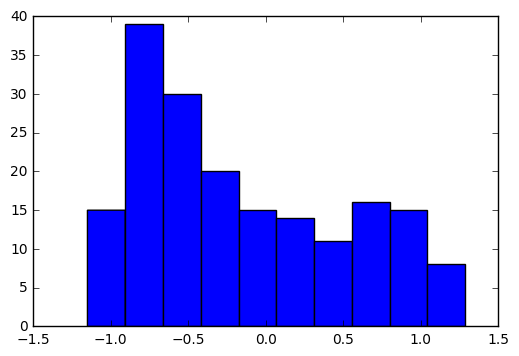

In [21]:
# This is unregulatized term
expt = 'H-time-gender-linear'
uid = 'DKF_lr-5_0000e-03-vm-R-inf-structured-dh-10-ds-10-nl-relu-bs-256-ep-3000-rs-20-ar-1_0000e+01-rv-0-uid'
cfac_file = '../../expt-mouse-puberty/chkpt-%s/%s-cfac.pkl' % (expt, uid)
# male_cfac = cfac['male_cfac']

# plotAllCfac(male_cfac)

cfac = getPKLData(cfac_file)
dim_vector = cfac['model_weights']['p_emis_b_mu']
print np.linalg.norm(dim_vector)
plt.hist(dim_vector)
plt.show()